# Importation des librairies nécessaires


In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, PrecisionRecallDisplay


## Charger les données

In [7]:
# Charger les données
df = pd.read_csv('ai4i2020.csv')
df_copy = df.copy()
df.head().describe


<bound method NDFrame.describe of    UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  \
0                    1551         42.8                0                0    0   
1                    1408         46.3                3                0    0   
2                    1498         49.4                5                0    0   
3                    1433         39.5                7                0    0   
4                    1408         40.0                9                0    0   

   HDF  PWF  OSF  RNF  
0    0    0    0    0 

## Vérification des valeurs manquantes

In [8]:
df.isnull().sum()
df.shape

(10000, 14)

## Vérification des doublons

In [9]:
df.duplicated().sum()
df.shape

(10000, 14)

## Visualisation initiale

Visualisation initiale des échecs des machines

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF
Machine failure,,,,,,,,,,,,,
0,9661,9661,9661,9661,9661,9661,9661,9661,9661,9661,9661,9661,9661
1,339,339,339,339,339,339,339,339,339,339,339,339,339


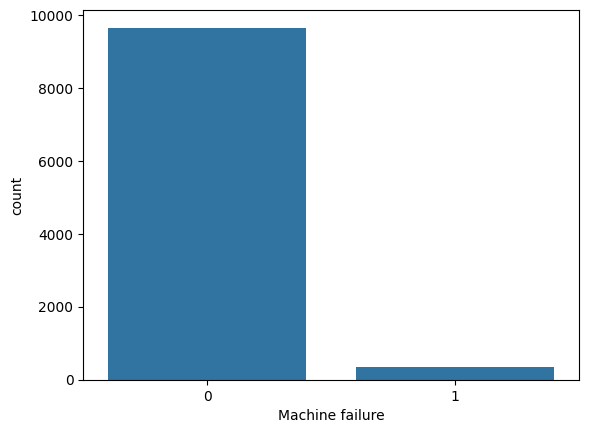

In [10]:
sns.countplot(x='Machine failure', data=df)
df.groupby(['Machine failure']).count()


## Prétraitement des données

In [11]:
# Convertir la colonne 'Type' en valeurs numériques
df['Type'] = df['Type'].replace(['L', 'M', 'H'], [0, 1, 2])

# Supprimer les colonnes non pertinentes
df.drop(columns=['UDI', 'Product ID'], inplace=True)

# Créer des nouvelles caractéristiques
df['Temperature difference'] = df['Process temperature [K]'] - df['Air temperature [K]']
df['Power'] = df['Torque [Nm]'] * df['Rotational speed [rpm]']
df.head()


C:\Users\MERYEM\AppData\Local\Temp\ipykernel_12232\477061873.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Type'] = df['Type'].replace(['L', 'M', 'H'], [0, 1, 2])


,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,Temperature difference,Power
0,1,298.1,308.6,1551,42.8,0,0,0,0,0,0,0,10.5,66382.8
1,0,298.2,308.7,1408,46.3,3,0,0,0,0,0,0,10.5,65190.4
2,0,298.1,308.5,1498,49.4,5,0,0,0,0,0,0,10.4,74001.2
3,0,298.2,308.6,1433,39.5,7,0,0,0,0,0,0,10.4,56603.5
4,0,298.2,308.7,1408,40.0,9,0,0,0,0,0,0,10.5,56320.0


## Analyse exploratoire des données

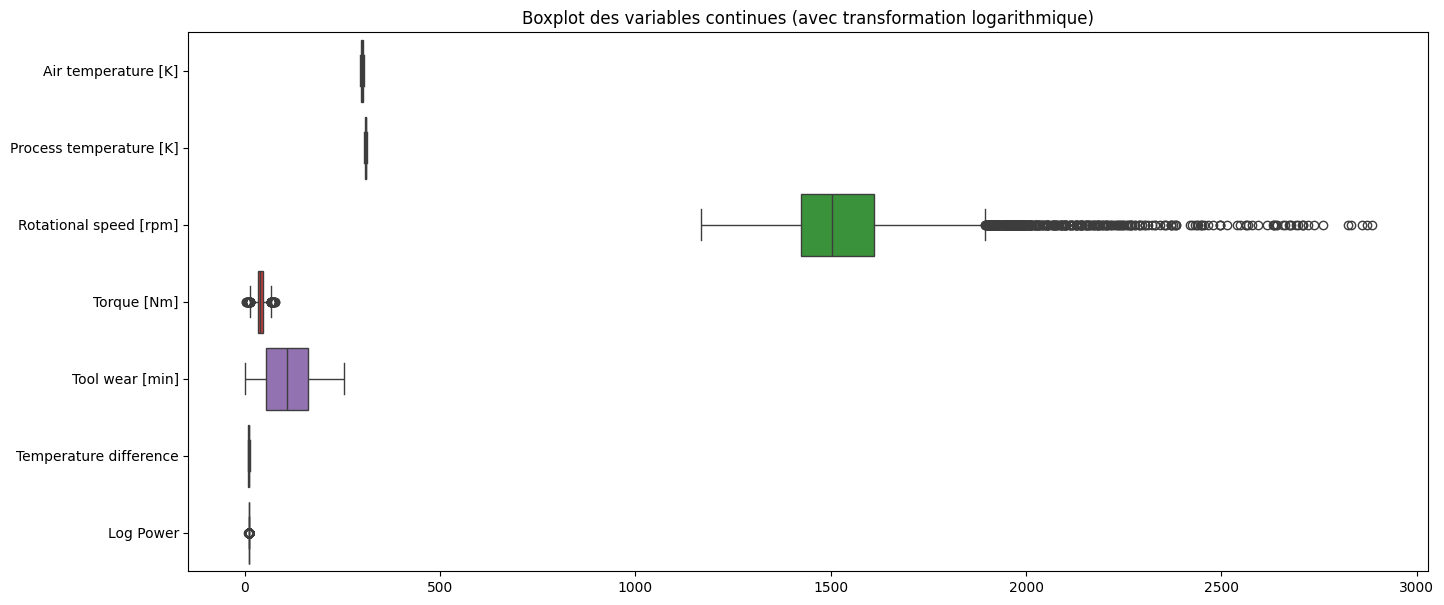

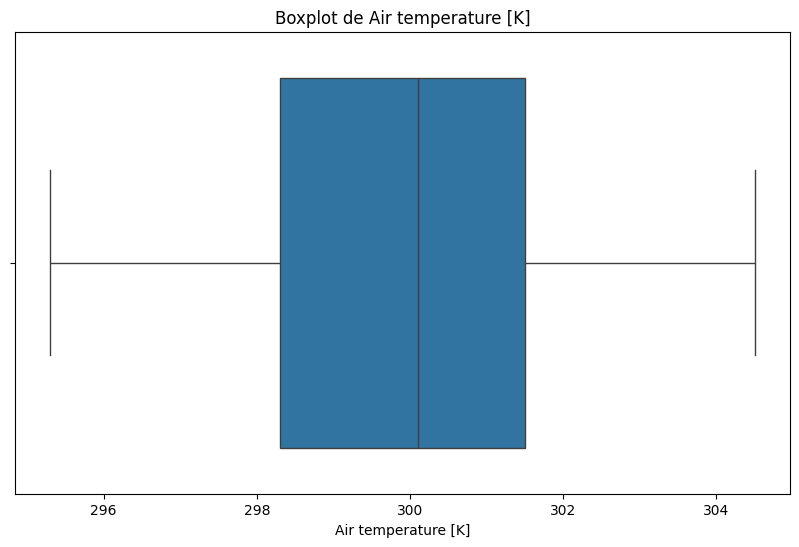

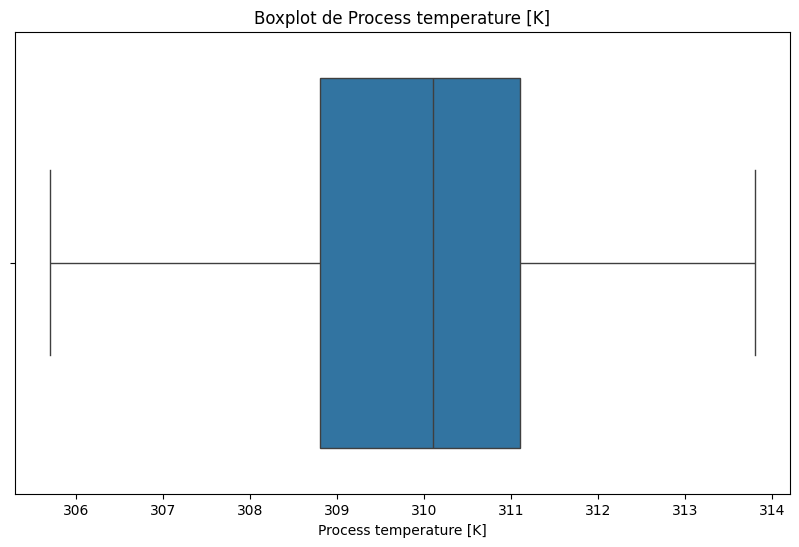

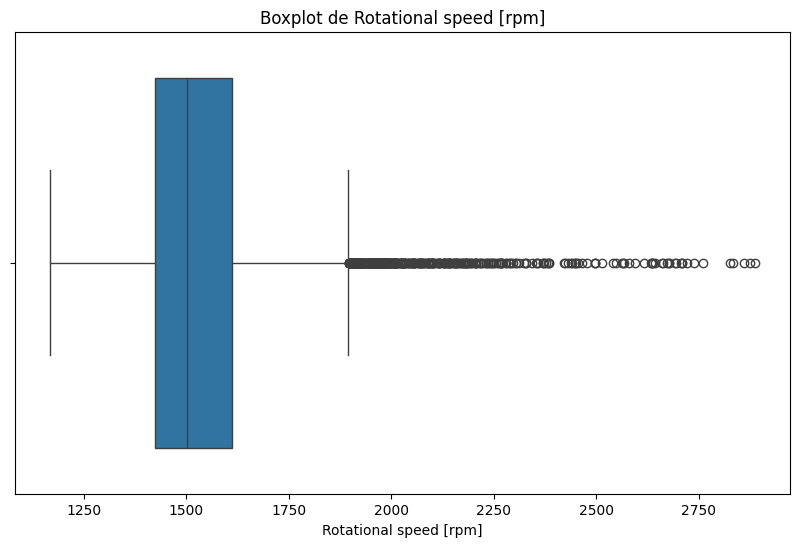

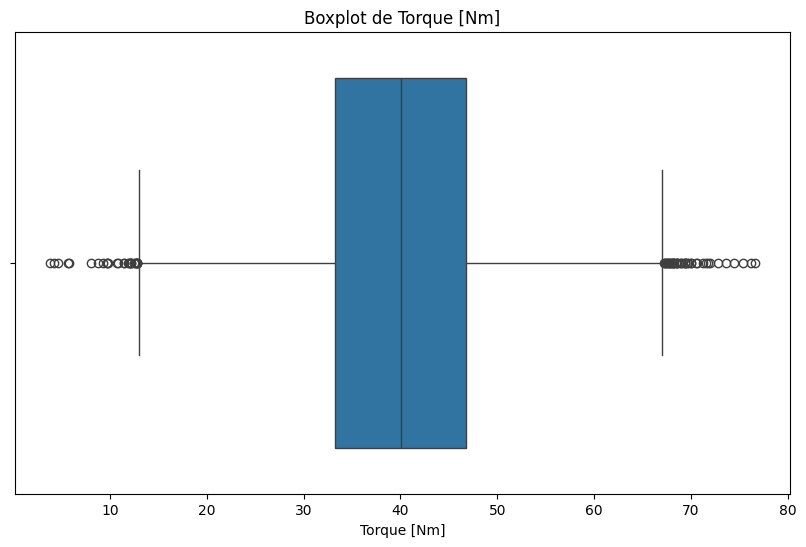

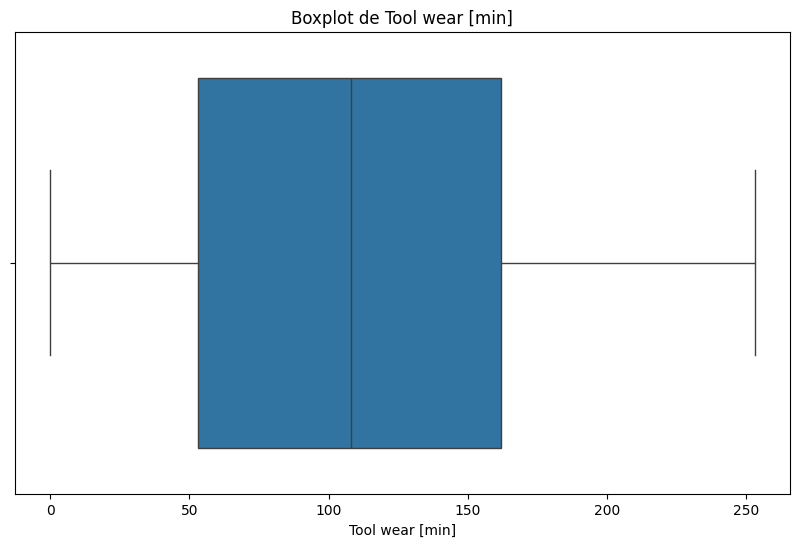

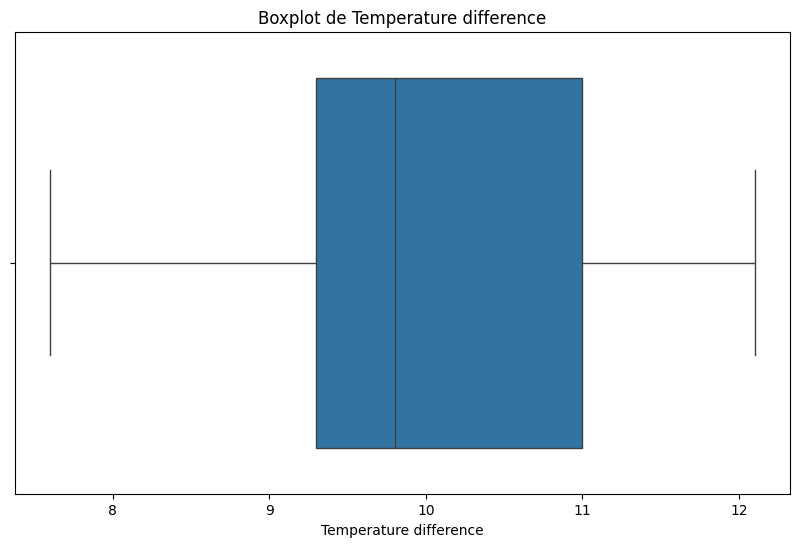

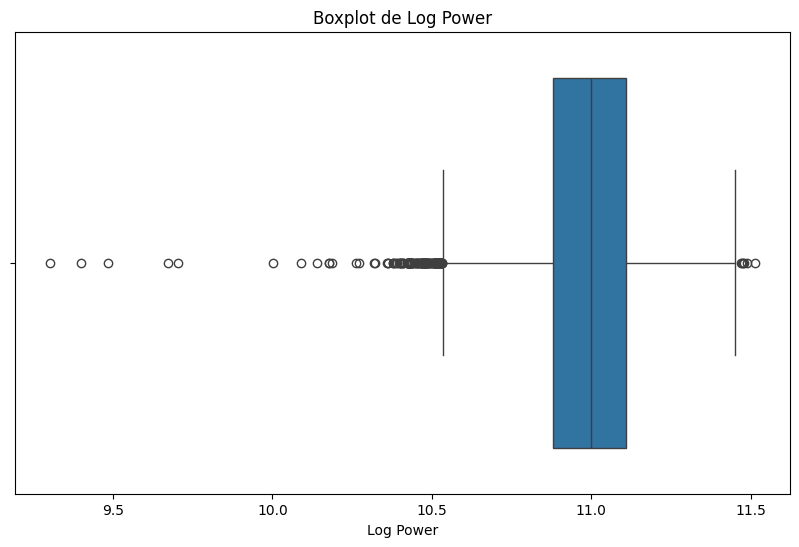

In [12]:
# Appliquer une transformation logarithmique à la variable 'Power'
df['Log Power'] = np.log1p(df['Power'])

# Refaire les boxplots avec la transformation logarithmique
cont_var_log = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Temperature difference', 'Log Power']

plt.figure(figsize=(16, 7))
ax = sns.boxplot(data=df[cont_var_log], orient='h')
ax.set_title('Boxplot des variables continues (avec transformation logarithmique)')
plt.show()
# Créer des boxplots séparés pour chaque variable
for var in cont_var_log:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df[var])
    plt.title(f'Boxplot de {var}')
    plt.show()


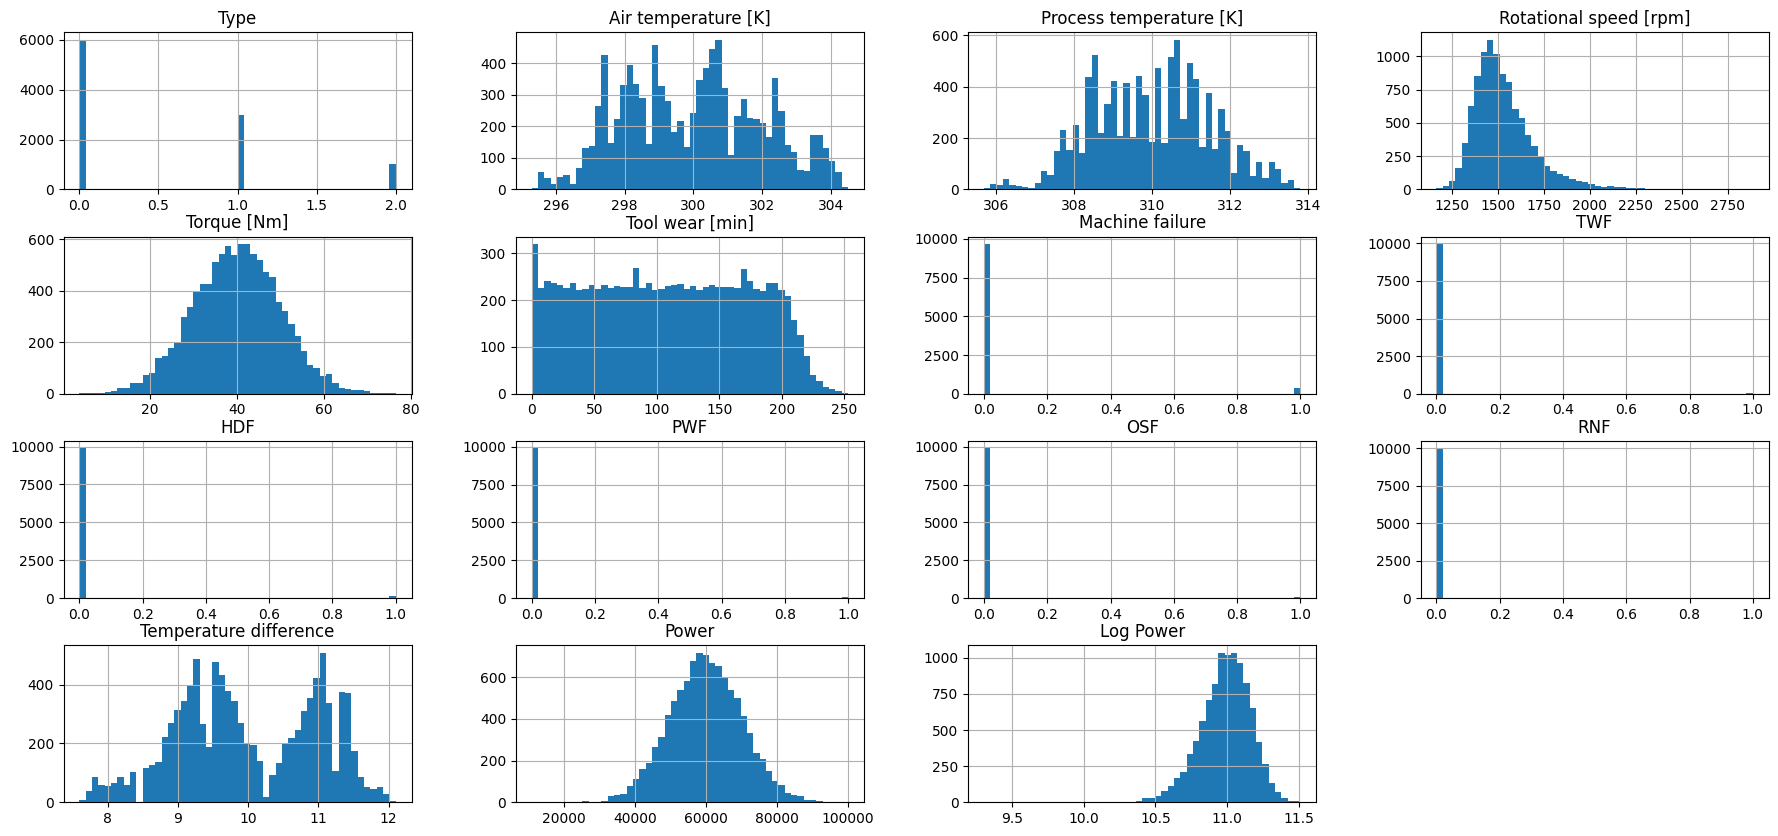

In [13]:
df.hist(figsize=(22, 10), bins=50)
plt.show()


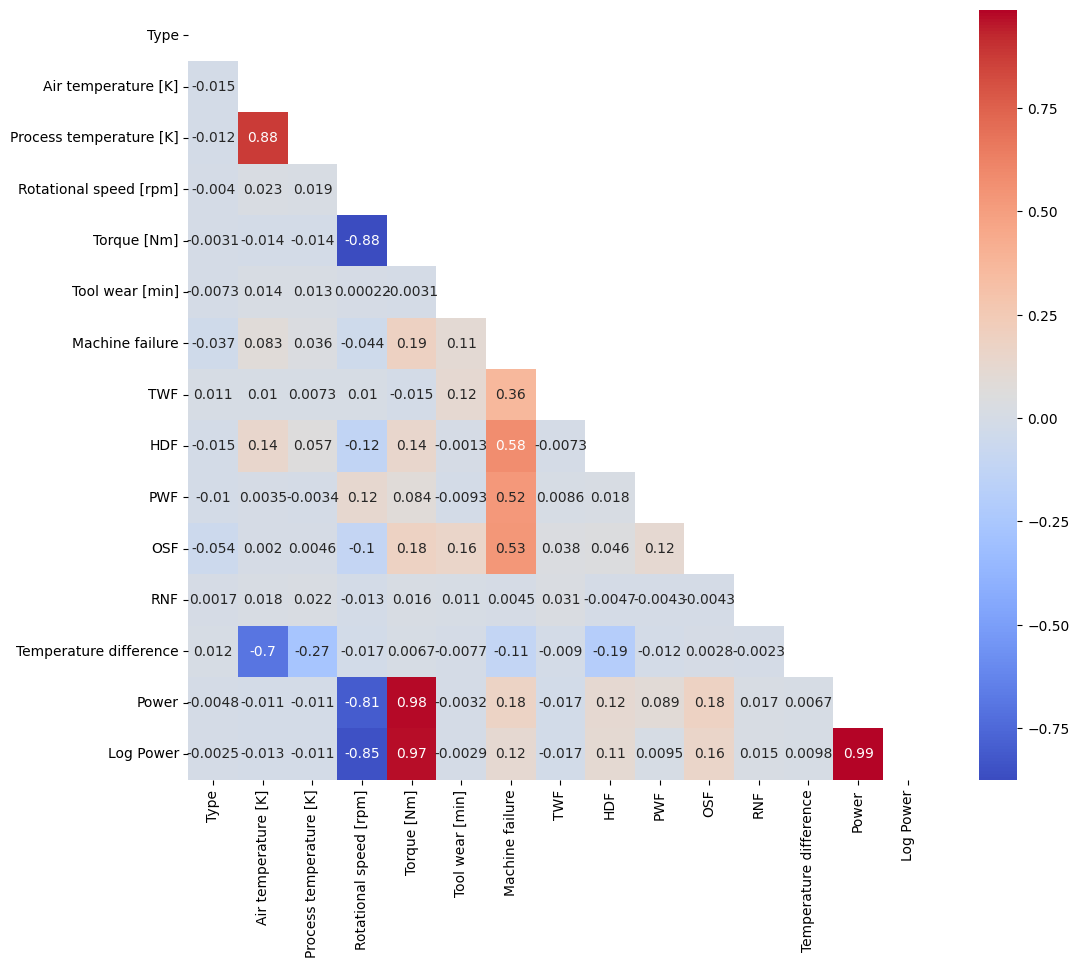

In [14]:
corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(12, 10))
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm')
plt.show()


## Modélisation

In [15]:
# Définir les caractéristiques et la variable cible
X = df.drop(columns=['Machine failure'])
y = df['Machine failure']

# Séparer les données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialiser les modèles
lr_model = LogisticRegression(max_iter=1000, penalty='l2', solver='lbfgs')
nb_model = GaussianNB()
rf_model = RandomForestClassifier(random_state=42)

# Entraîner les modèles
lr_model.fit(X_train, y_train)
nb_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

# Scores de validation croisée
lr_scores = cross_val_score(lr_model, X, y, cv=5)
nb_scores = cross_val_score(nb_model, X, y, cv=5)
rf_scores = cross_val_score(rf_model, X, y, cv=5)

# Calculer la précision moyenne
lr_accuracy = lr_scores.mean()
nb_accuracy = nb_scores.mean()
rf_accuracy = rf_scores.mean()

# Créer un DataFrame pour comparer les modèles
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Naive Bayes', 'Random Forest'],
    'Accuracy': [lr_accuracy, nb_accuracy, rf_accuracy]
})

results


C:\Users\MERYEM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\MERYEM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/st

,Model,Accuracy
0,Logistic Regression,0.9973
1,Naive Bayes,0.9742
2,Random Forest,0.9268


## Visualisation des performances des modèles

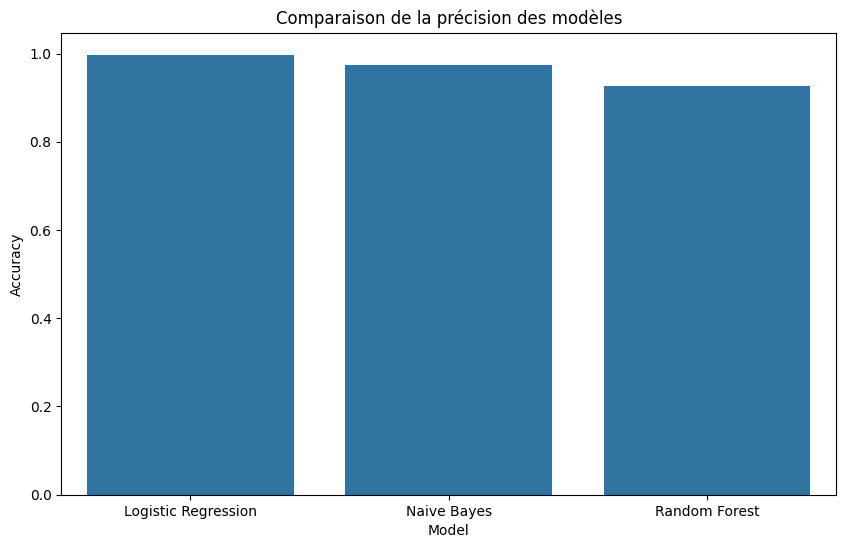

In [16]:
# Comparaison de la précision des modèles
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=results)
plt.title('Comparaison de la précision des modèles')
plt.show()


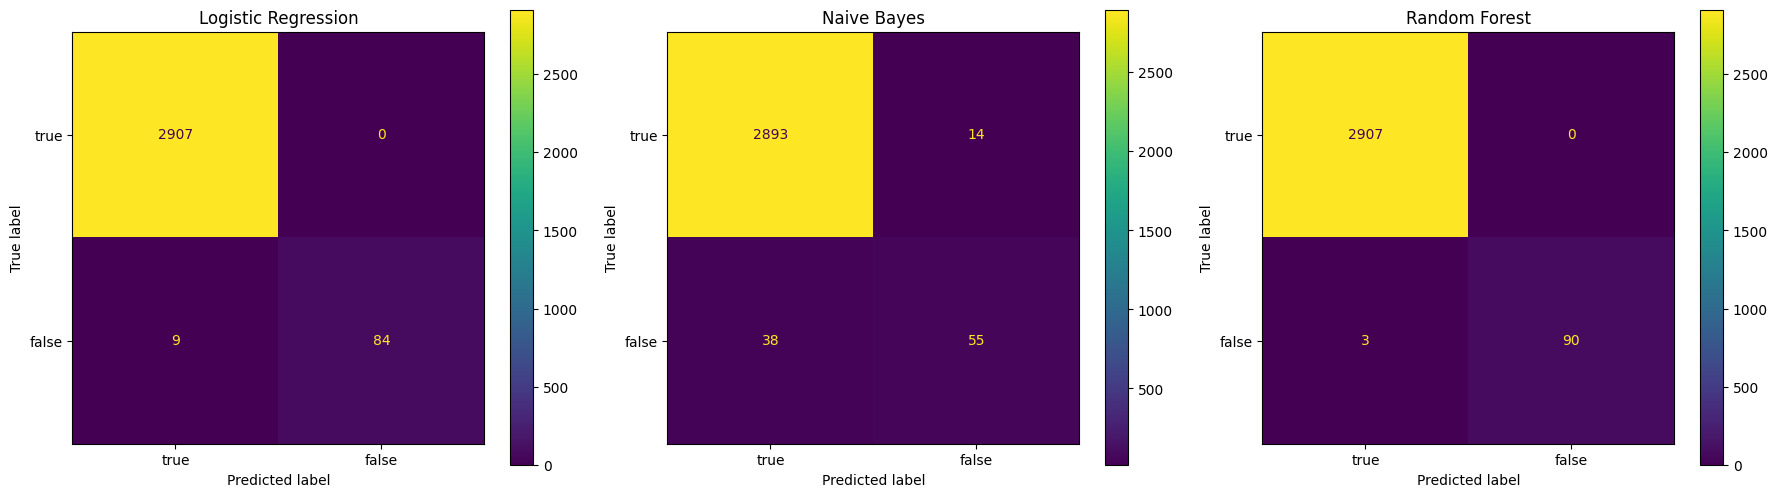

In [17]:
# Matrices de confusion
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
for ax, model, title in zip(axs, [lr_model, nb_model, rf_model], ['Logistic Regression', 'Naive Bayes', 'Random Forest']):
    cm = confusion_matrix(y_test, model.predict(X_test))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['true', 'false'])
    disp.plot(ax=ax)
    ax.set_title(title)
plt.tight_layout()
plt.show()


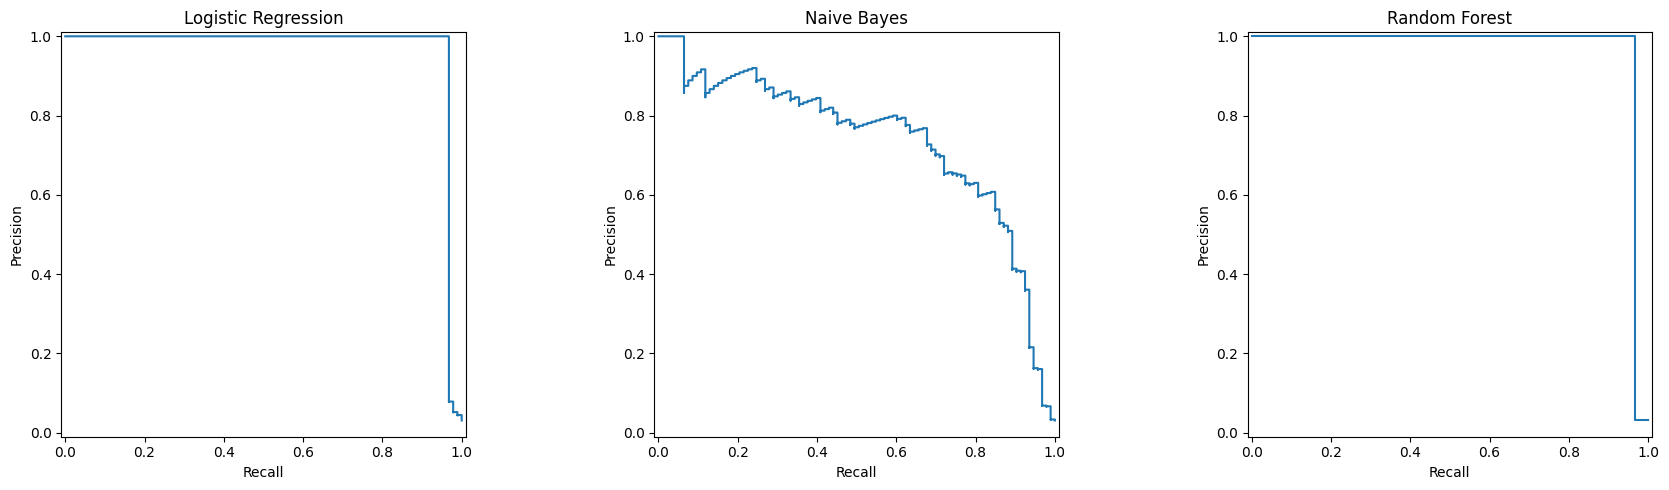

In [18]:
# Courbes de précision-rappel
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
for ax, model, title in zip(axs, [lr_model, nb_model, rf_model], ['Logistic Regression', 'Naive Bayes', 'Random Forest']):
    y_scores = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    disp.plot(ax=ax)
    ax.set_title(title)
plt.tight_layout()
plt.show()


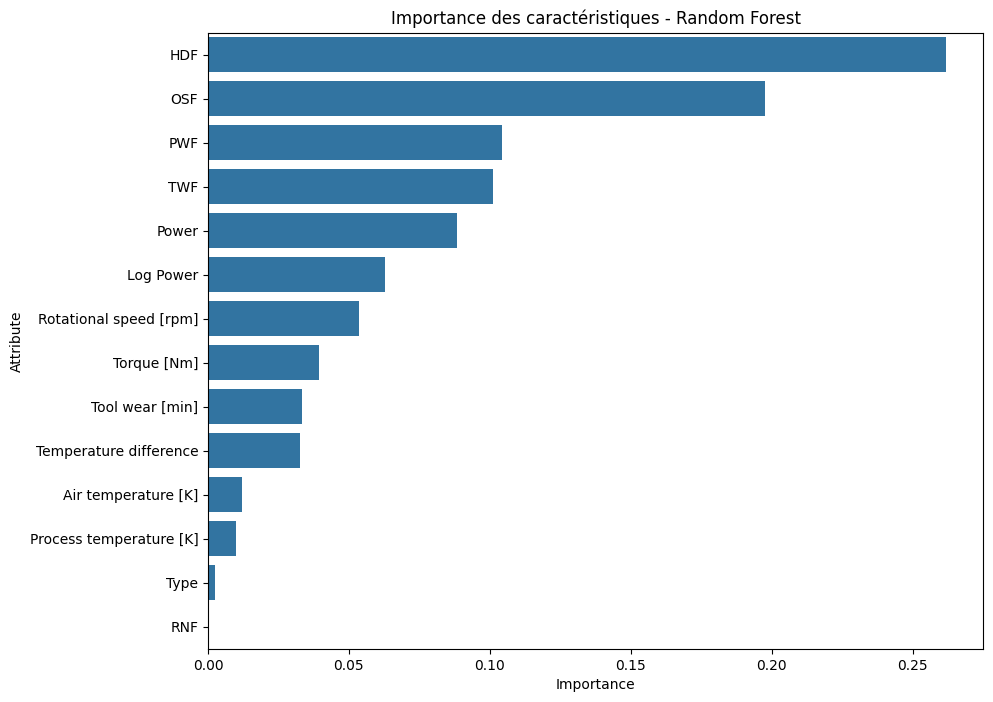

In [19]:
# Importance des caractéristiques (Random Forest)
importances = pd.DataFrame(data={
    'Attribute': X.columns,
    'Importance': rf_model.feature_importances_
})

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Attribute', data=importances.sort_values(by='Importance', ascending=False))
plt.title('Importance des caractéristiques - Random Forest')
plt.show()


## Optimisation des Hyperparamètres

## Optimisation des Hyperparamètres avec Normalisation

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Normaliser les données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Optimisation des hyperparamètres pour la Régression Logistique avec normalisation
lr_param_grid = {
    'solver': ['lbfgs', 'sag', 'saga'],
    'C': [0.1, 1, 10]
}
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(max_iter=5000))  # Augmentation du nombre maximal d'itérations
])
grid_search_lr = GridSearchCV(estimator=pipeline_lr, param_grid={'lr__' + key: val for key, val in lr_param_grid.items()}, cv=5)
grid_search_lr.fit(X_train, y_train)
best_params_lr = grid_search_lr.best_params_
best_lr_model = LogisticRegression(max_iter=5000, **{key.split('__')[1]: val for key, val in best_params_lr.items()})
best_lr_model.fit(X_train_scaled, y_train)

# Optimisation des hyperparamètres pour Random Forest
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
grid_search_rf = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=rf_param_grid, cv=5)
grid_search_rf.fit(X_train, y_train)
best_params_rf = grid_search_rf.best_params_
best_rf_model = RandomForestClassifier(random_state=42, **best_params_rf)
best_rf_model.fit(X_train, y_train)

best_params_lr, best_params_rf


({'lr__C': 0.1, 'lr__solver': 'lbfgs'},
 {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100})

## Évaluation Complète des Modèles

C:\Users\MERYEM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\MERYEM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


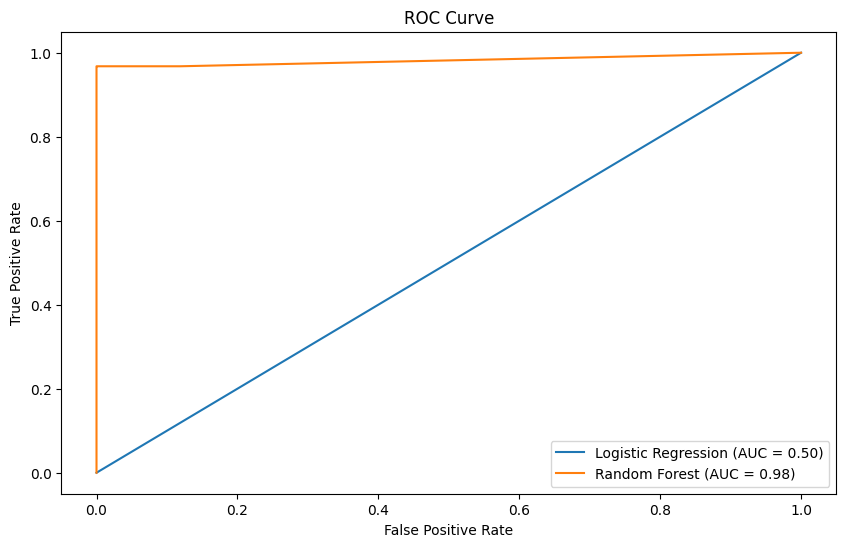

,Model,F1 Score,ROC AUC
0,Logistic Regression,0.060136,0.500000
1,Random Forest,0.983607,0.981957


In [21]:
# Evaluation complète des modèles avec des métriques supplémentaires
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc

# Prédictions et probabilités pour les meilleurs modèles
y_pred_lr = best_lr_model.predict(X_test)
y_pred_rf = best_rf_model.predict(X_test)
y_proba_lr = best_lr_model.predict_proba(X_test)[:, 1]
y_proba_rf = best_rf_model.predict_proba(X_test)[:, 1]

# Calcul des métriques
f1_lr = f1_score(y_test, y_pred_lr)
f1_rf = f1_score(y_test, y_pred_rf)
roc_auc_lr = roc_auc_score(y_test, y_proba_lr)
roc_auc_rf = roc_auc_score(y_test, y_proba_rf)

# Courbes ROC
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)

# Affichage des résultats
results_extended = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest'],
    'F1 Score': [f1_lr, f1_rf],
    'ROC AUC': [roc_auc_lr, roc_auc_rf]
})

# Courbes ROC
plt.figure(figsize=(10, 6))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

results_extended


## Extension de l'Analyse

In [22]:
# Utilisation d'autres modèles de machine learning
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

# Initialisation des modèles
svm_model = SVC(probability=True, random_state=42)
gb_model = GradientBoostingClassifier(random_state=42)

# Entraînement des modèles
svm_model.fit(X_train, y_train)
gb_model.fit(X_train, y_train)

# Prédictions et probabilités
y_pred_svm = svm_model.predict(X_test)
y_pred_gb = gb_model.predict(X_test)
y_proba_svm = svm_model.predict_proba(X_test)[:, 1]
y_proba_gb = gb_model.predict_proba(X_test)[:, 1]

# Calcul des métriques
f1_svm = f1_score(y_test, y_pred_svm)
f1_gb = f1_score(y_test, y_pred_gb)
roc_auc_svm = roc_auc_score(y_test, y_proba_svm)
roc_auc_gb = roc_auc_score(y_test, y_proba_gb)

# Affichage des résultats
results_extended_more = pd.DataFrame({
    'Model': ['SVM', 'Gradient Boosting'],
    'F1 Score': [f1_svm, f1_gb],
    'ROC AUC': [roc_auc_svm, roc_auc_gb]
})

results_combined = pd.concat([results_extended, results_extended_more], ignore_index=True)
results_combined


,Model,F1 Score,ROC AUC
0,Logistic Regression,0.060136,0.500000
1,Random Forest,0.983607,0.981957
2,SVM,0.000000,0.794782
3,Gradient Boosting,0.983607,0.980255


## Transformation Logarithmique et Zoom sur les Variables

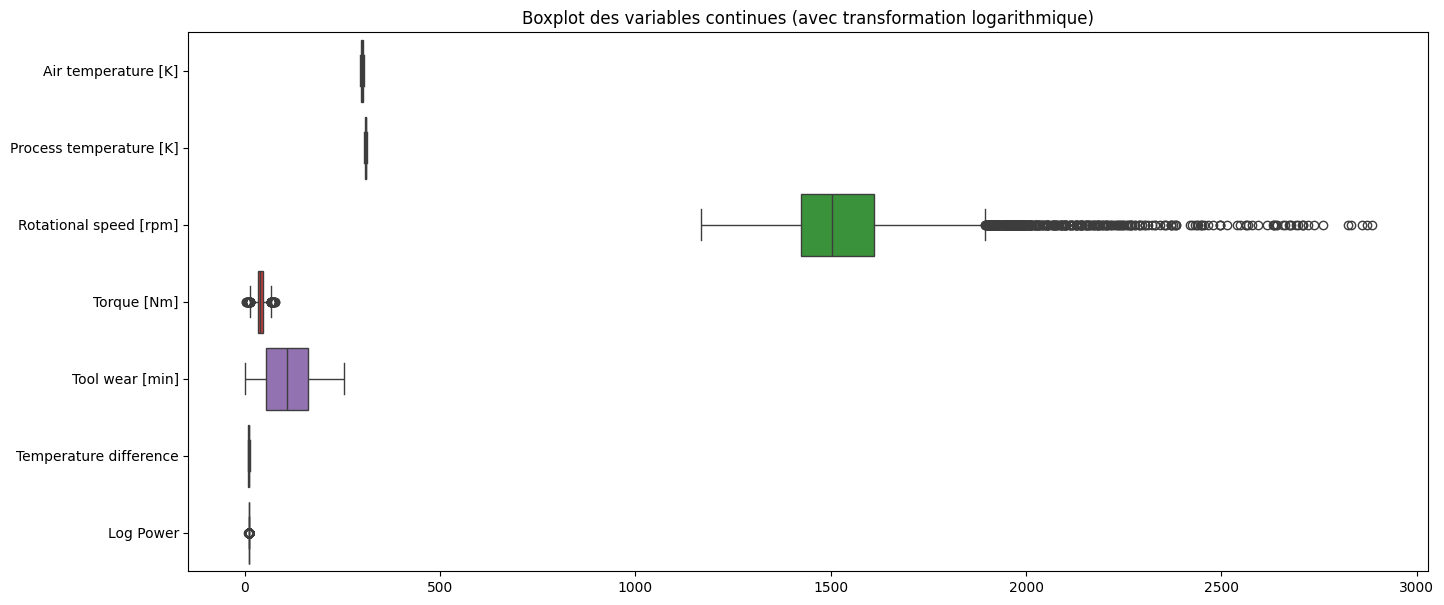

In [23]:
# Appliquer une transformation logarithmique à la variable 'Power'
df['Log Power'] = np.log1p(df['Power'])

# Refaire les boxplots avec la transformation logarithmique
cont_var_log = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Temperature difference', 'Log Power']

plt.figure(figsize=(16, 7))
ax = sns.boxplot(data=df[cont_var_log], orient='h')
ax.set_title('Boxplot des variables continues (avec transformation logarithmique)')
plt.show()


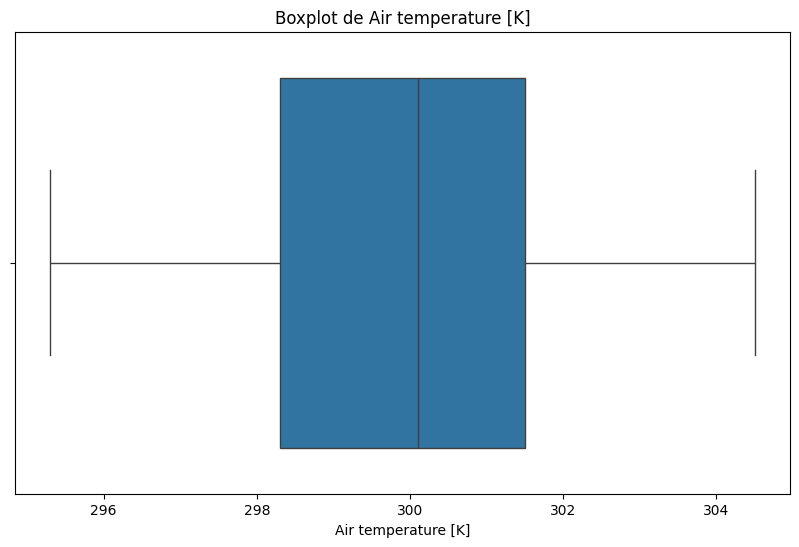

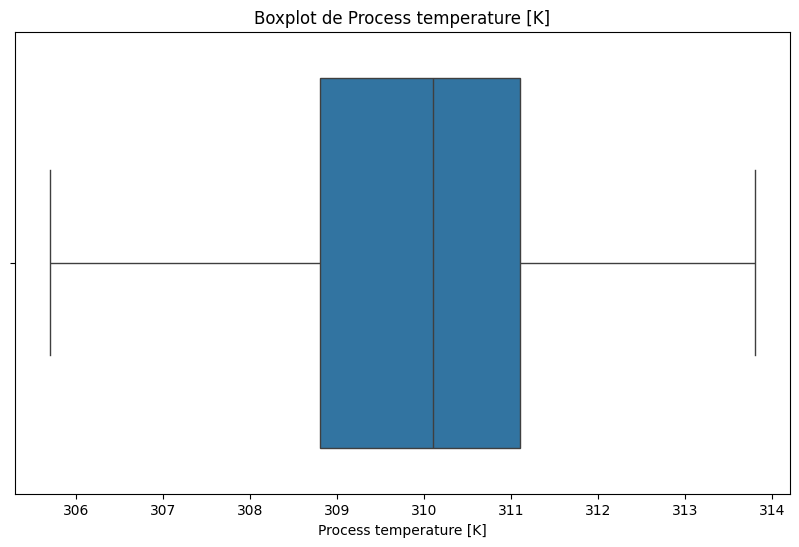

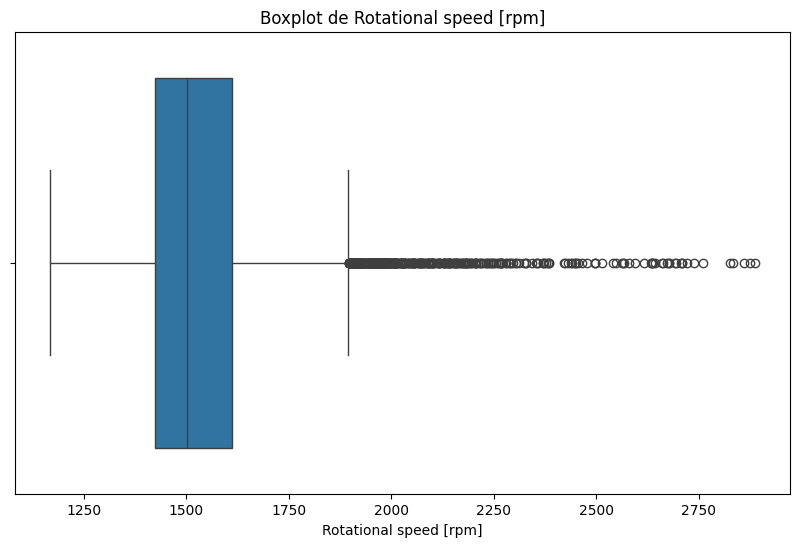

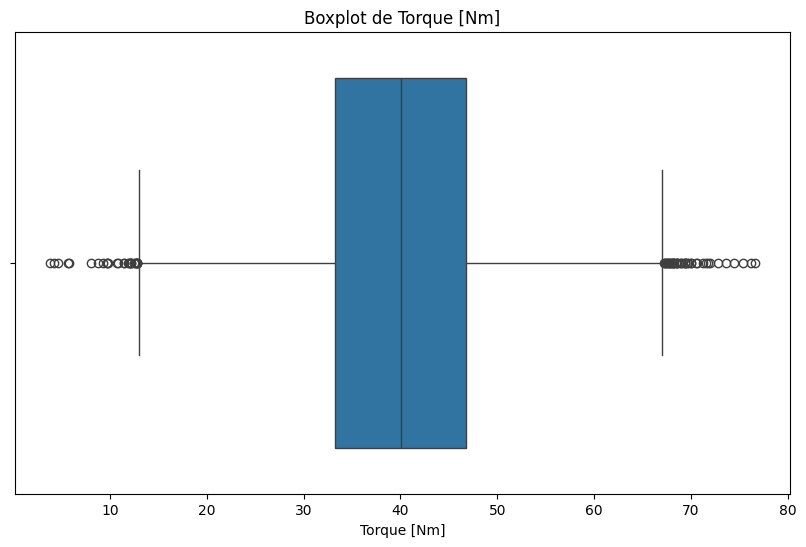

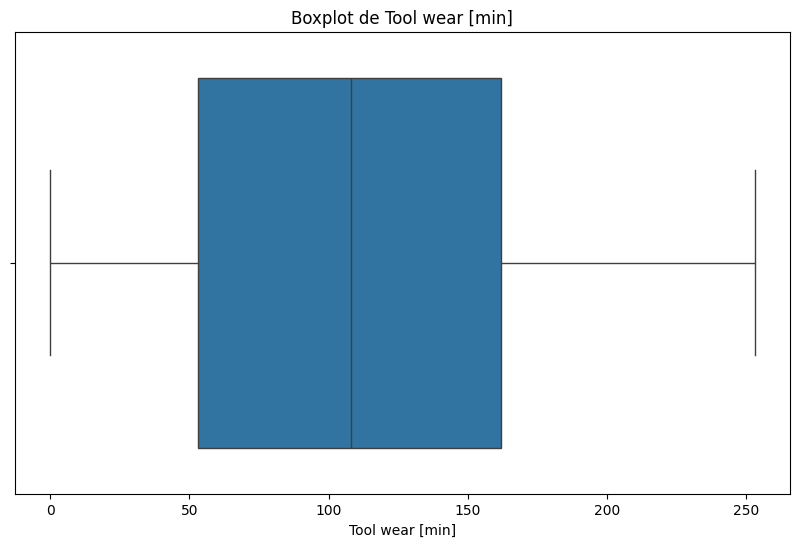

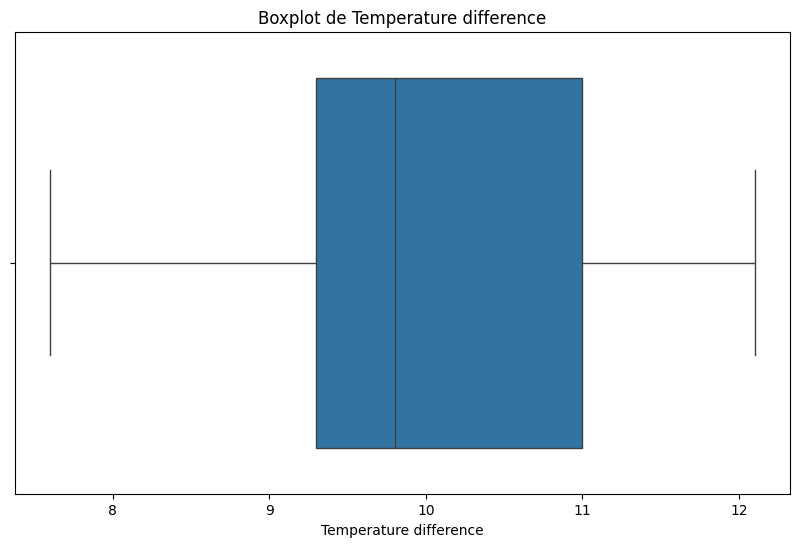

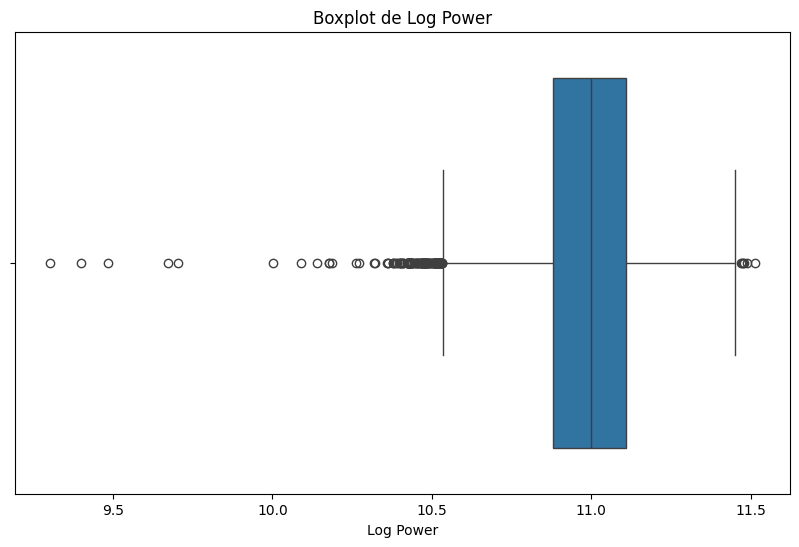

In [24]:
# Créer des boxplots séparés pour chaque variable
for var in cont_var_log:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df[var])
    plt.title(f'Boxplot de {var}')
    plt.show()
